* classification / regression : 지도학습
* clustering / dimensionality reduction : 비지도학습

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("data/diabetes.csv")
df.shape

(768, 9)

In [3]:
# 전처리 할 때 이전에는 BMI가 0인 것 등을 중앙값, 평균값으로 바꿨었다.

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 학습, 예측 데이터셋 나누기

* 보통 예측 데이터보다 학습 데이터가 많아야지 좀 더 잘 학습됨
* Insulin 값을 예측해서 결측치를 채우는 것이 목표이기 때문에, 인슐린 값이 0일때가 결측치라고 볼 수 있으므로 이를 기준으로 나눈다.

In [6]:
(df['Insulin'] > 0).value_counts()

True     394
False    374
Name: Insulin, dtype: int64

In [9]:
# train set
train = df[df['Insulin'] > 0].copy()
train.shape

(394, 9)

In [11]:
# test set
test = df[df['Insulin'] == 0].copy()
test.shape

(374, 9)

## EDA

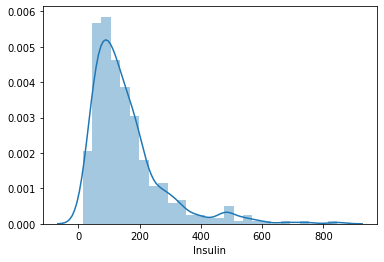

In [67]:
sns.distplot(train['Insulin'])

# 600 이상 정도에 이상치가 많다.

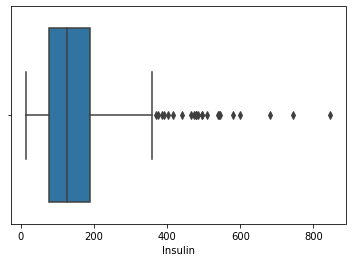

In [68]:
sns.boxplot(train['Insulin'])

In [70]:
desc = train['Insulin'].describe()
desc

count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [76]:
# Outlier
IQR = desc.loc['75%'] - desc.loc['25%']
OUT = (IQR * 1.5) + desc.loc['75%']

In [77]:
train[train['Insulin'] > OUT].shape

(24, 9)

In [100]:
print(train.shape) # 얘 원래 print하면 (394, 9) 였음!!
## train = train[train['Insulin'] < 600] ; 우선 위에 24개 다 지우면 너무 적어지니까, 600 이상의 진짜 극단적인 애들만 지워준다. 그리고 그걸 train set으로한다.
train = train[train['Insulin'] < OUT] # 이번엔 OUT 다 제거
train.shape

(390, 9)


(370, 9)

## 학습, 예측에 사용할 컬럼

In [101]:
feature_names = test.columns.tolist()
feature_names.remove('Insulin')
feature_names

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

## 정답값이자 예측해야 될 값

In [102]:
label_name = 'Insulin'
label_name

'Insulin'

## 학습, 예측 데이터셋 만들기

In [103]:
X_train = train[feature_names]
X_train.shape

(370, 8)

In [104]:
y_train = train[label_name]
y_train.shape

(370,)

In [105]:
X_test = test[feature_names]
X_test.shape

(374, 8)

In [106]:
y_test = test[label_name]
y_test.shape #어차피 다 0

(374,)

## 머신러닝 알고리즘 가져오기

* Ridge,Lasso,Elastic Net 이 있지만, classifier에도 사용 가능한 tree 기반 알고리즘 사용

In [107]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

## 학습(훈련)

In [108]:
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

## Cross Validation으로 학습 세트의 오차 측정하기

In [109]:
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(model, X_train, y_train, cv=5, verbose=2, n_jobs=-1)
y_predict[:5]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


array([ 25., 182.,  55., 144., 220.])

In [110]:
# 정답을 정확하게 맞춘 개수 394개 중 3개
# 이상치 600이상을 제거하고나서는 5개로 증가, OUT 제거는 7

(y_predict == y_train).sum()

7

In [111]:
len(y_train)

370

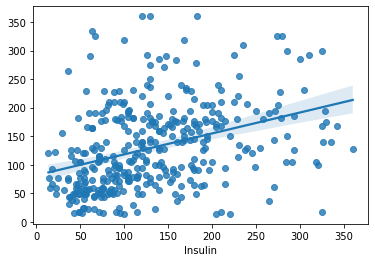

In [112]:
sns.regplot(y_train, y_predict)

In [113]:
from sklearn.metrics import r2_score

r2_score(y_train, y_predict)

-0.28551906710833275

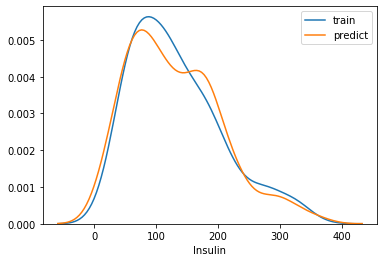

In [114]:
sns.distplot(y_train, hist=False, label='train')
sns.distplot(y_predict, hist=False, label='predict')

## 오차 구하기

In [115]:
# MAE
# 86 -> 77.55(600이상 outlier 삭제) -> 62.056(OUT 제거)
error = abs(y_train - y_predict)
error.mean()

62.056756756756755

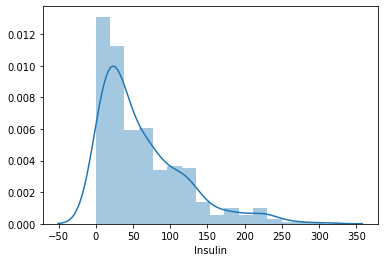

In [116]:
sns.distplot(error)

In [117]:
error.describe()

count    370.000000
mean      62.056757
std       56.854443
min        0.000000
25%       19.250000
50%       42.500000
75%       89.750000
max      307.000000
Name: Insulin, dtype: float64

In [118]:
# RMSE
# 126.895 -> 114.077 -> 84.111

np.sqrt(((y_train - y_predict)**2).mean())

84.11142866717003

## 트리 알고리즘 분석하기

* 의사결정나무를 시각화 합니다
* 피처의 중요도를 구합니다

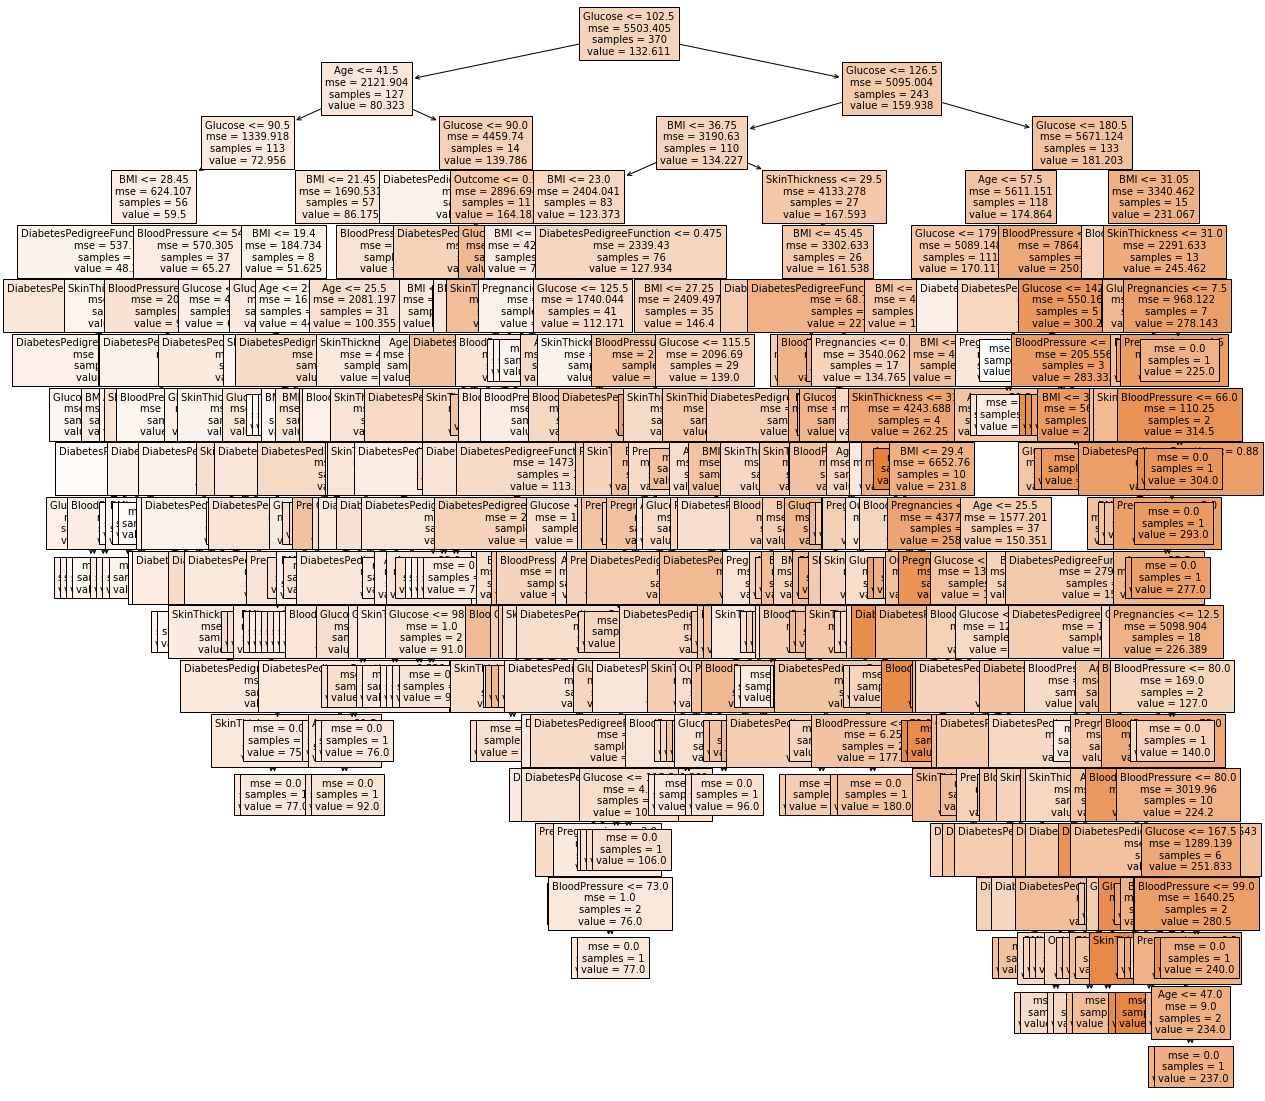

In [119]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
tree = plot_tree(model, feature_names = feature_names, filled=True, fontsize=10)

In [120]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.04858345, 0.44656558, 0.07097731, 0.05588694, 0.16087336,
       0.09607089, 0.11025783, 0.01078464])

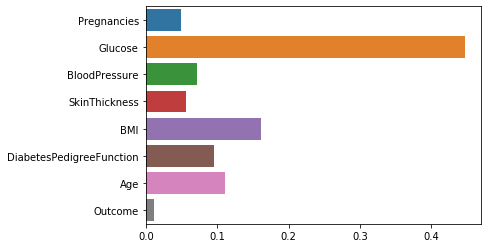

In [121]:
# 피처의 중요도 시각화 하기
sns.barplot(x=model.feature_importances_, y=feature_names)

## 예측

In [122]:
y_test = model.predict(X_test)
y_test[:5]

array([168.,  37., 130., 215., 165.])

In [123]:
train.groupby("Outcome")['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,254.0,115.917323,69.844697,15.0,64.25,100.0,151.00,342.0
1,116.0,169.163793,70.789454,14.0,124.25,160.0,207.75,360.0


In [124]:
test['Insulin'] = y_test

In [125]:
test.groupby("Outcome")['Insulin'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,236.0,124.906780,80.878263,18.0,64.00,97.5,155.0,335.0
1,138.0,163.724638,83.718835,14.0,96.75,145.0,215.0,328.0


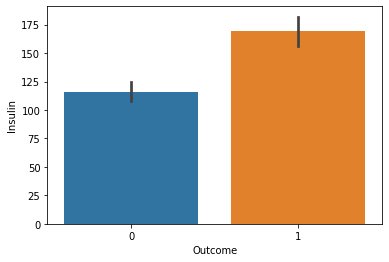

In [126]:
# Outcome에 따른 Insulin의 평균값
sns.barplot(data=train, x='Outcome', y='Insulin')

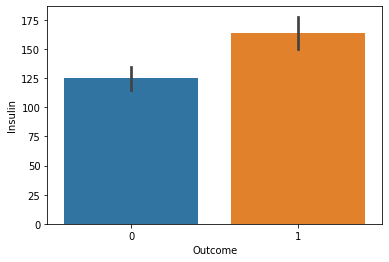

In [127]:
# 예측값에 대한 시각화
sns.barplot(data=test, x='Outcome', y='Insulin')